In [3]:
import sys
import os
path = os.path.abspath("../")
sys.path.append(path)
print(path)

/home/jovyan


In [4]:
import torch
from torch.utils.data import DataLoader, TensorDataset, Sampler, random_split, Dataset, Subset
from torchvision import datasets, transforms

import matplotlib.pyplot as plt
import numpy as np
import math
import pandas as pd
import random


import src.helpers.MetricUtilities as metrics
import src.data_processing.ImageProducts as ImageProducts

from mtree.mtree import MTree
import mtree.mtree as mtree

import glob
from PIL import Image

import time
import json
import xml.etree.ElementTree as ET


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

%reload_ext autoreload

%autoreload 2

cpu


In [5]:
def getKNearestNeighbours(tree, point, k):
    l = tree.search(point, k)
    imgs = list(l)
    return imgs

def getMTree(data, k, promote=mtree.M_LB_DIST_confirmed, partition=mtree.generalized_hyperplane, d=metrics.distance):
    # k: desired number of nearest neighbours
    tree = MTree(d, max_node_size=k, promote=promote, partition=partition)
    tree.add_all(data)
    return tree

def getMTreeFFT(data, k):
    # k: desired number of nearest neighbours
    tree = MTree(metrics.dist_fft, max_node_size=k)
    tree.add_all(data)
    return tree

def getMTreeFFTNumba(data, k, promote=mtree.M_LB_DIST_confirmed, partition=mtree.generalized_hyperplane):
    # k: desired number of nearest neighbours
    tree = MTree(metrics.dist_fft_numba, max_node_size=k, promote=promote, partition=partition)
    tree.add_all(data)
    return tree

In [4]:
'''
SAVING TO DICTIONARY SORTING FILEPATHS BY CLASS
'''


imgs_path = "/home/jovyan/data/ATRNet-STAR/EOC_azimuth/test_60/"
file_list = glob.glob(imgs_path + "*/")
# file_list = [glob.glob(annotation_path + "*.json")]
print(file_list)
# for file in file_list:
#     with open(file) as f:
#         annotations = json.load(f)
    
type_names = ["Excelle_GT", "GL8", "CS75_Plus", "Starlight_4500", "Cheetah_CFA6473C", "8228-5", "Arrizo 5", "qq3", "Blazer_1998", "HOWO", "Duolika", "EQ6608LTV", "Forthing_Lingzhi",
        "Tianjin_DFH2200B", "Tianjin_KR230", "J6P", "Jiabao_T51", "BJ1045V9JB5-54", "Wall_poer", "Wall_Voleex_C50", "EV160B", "CA7180A3E", "h5", "N1", "HLF25_II", "Junling", "Patriot", 
        "SY5033XJH", "MKC", "Proud_2009", "V80", "Outlander_2003", "ZL40F", "DeLong_M3000", "DeLong_X3000", "Aochi_1800", "Aochi_Hongrui", "Rongguang_V", "YZK6590XCA", "ZK6120HY1"]
categories = {}
for i in range(len(type_names)):
    categories[type_names[i]] = []



for file in file_list:
    for xml_file_path in glob.glob(file + "*.xml"):
        # print(xml_file_path)
        tree = ET.parse(xml_file_path)
        root = tree.getroot()
        img_path = root.find('filename').text
        img_path = file + img_path
        subclass_type = "_".join(root.find('object').find('type').text.split("_")[1:])
        categories[subclass_type] = categories[subclass_type] + [img_path]

# for dir_path in file_list:
#     for cat in glob.glob(dir_path + "*"):
#         print(cat)
#         for xml_file_path in glob.glob(cat + "/*.xml"):
#             print(xml_file_path)
#             tree = ET.parse(xml_file_path)
#             root = tree.getroot()
#             img_path = root.find('filename').text
#             img_path = cat + "/" + img_path
#             # broad_class = root.find('object').find('class').text
#             # subclass = root.find('object').find('subclass').text
#             subclass_type = "_".join(root.find('object').find('type').text.split("_")[1:])
#             # chip_data = [img_path, broad_class, subclass, subclass_type]
#             # adding chipdata to the dictionary entry w that class name
#             # self.categories[subclass_type] = self.categories[subclass_type] + chip_data
#             categories[subclass_type] = categories[subclass_type] + [img_path]
#         print(categories)
#             # self.data.append(chip_data)

    print(categories)

with open('/home/jovyan/data/EOC_azimuth_test_60_byclass.json', 'w', encoding='utf-8') as f:
    json.dump(categories, f, ensure_ascii=False, indent=4)




['/home/jovyan/data/ATRNet-STAR/EOC_azimuth/test_60/Buick_Excelle_GT/', '/home/jovyan/data/ATRNet-STAR/EOC_azimuth/test_60/Buick_GL8/', '/home/jovyan/data/ATRNet-STAR/EOC_azimuth/test_60/CNHTC_HOWO/', "/home/jovyan/data/ATRNet-STAR/EOC_azimuth/test_60/Chang'an_CS75_Plus/", "/home/jovyan/data/ATRNet-STAR/EOC_azimuth/test_60/Chang'an_Starlight_4500/", '/home/jovyan/data/ATRNet-STAR/EOC_azimuth/test_60/Changfeng_Cheetah_CFA6473C/', '/home/jovyan/data/ATRNet-STAR/EOC_azimuth/test_60/Changlin_8228-5/', '/home/jovyan/data/ATRNet-STAR/EOC_azimuth/test_60/Chery_Arrizo 5/', '/home/jovyan/data/ATRNet-STAR/EOC_azimuth/test_60/Chery_qq3/', '/home/jovyan/data/ATRNet-STAR/EOC_azimuth/test_60/Chevrolet_Blazer_1998/', '/home/jovyan/data/ATRNet-STAR/EOC_azimuth/test_60/Dongfeng_Duolika/', '/home/jovyan/data/ATRNet-STAR/EOC_azimuth/test_60/Dongfeng_EQ6608LTV/', '/home/jovyan/data/ATRNet-STAR/EOC_azimuth/test_60/Dongfeng_Forthing_Lingzhi/', '/home/jovyan/data/ATRNet-STAR/EOC_azimuth/test_60/Dongfeng_Tian

KeyboardInterrupt: 

In [5]:
def sort_by_class(imgs_path, file_list):
    # file_list = glob.glob(imgs_path + "*/")
    # print(file_list)


    type_names = ["Excelle_GT", "GL8", "CS75_Plus", "Starlight_4500", "Cheetah_CFA6473C", "8228-5", "Arrizo 5", "qq3", "Blazer_1998", "HOWO", "Duolika", "EQ6608LTV", "Forthing_Lingzhi",
            "Tianjin_DFH2200B", "Tianjin_KR230", "J6P", "Jiabao_T51", "BJ1045V9JB5-54", "Wall_poer", "Wall_Voleex_C50", "EV160B", "CA7180A3E", "h5", "N1", "HLF25_II", "Junling", "Patriot", 
            "SY5033XJH", "MKC", "Proud_2009", "V80", "Outlander_2003", "ZL40F", "DeLong_M3000", "DeLong_X3000", "Aochi_1800", "Aochi_Hongrui", "Rongguang_V", "YZK6590XCA", "ZK6120HY1"]
    categories = {}
    for i in range(len(type_names)):
        categories[type_names[i]] = []

    for dir_path in file_list:
        for cat in glob.glob(dir_path + "*"):
            for xml_file_path in glob.glob(cat + "/*.xml"):
                tree = ET.parse(xml_file_path)
                root = tree.getroot()
                img_path = root.find('filename').text
                img_path = cat + "/" + img_path
                subclass_type = "_".join(root.find('object').find('type').text.split("_")[1:])
                categories[subclass_type] = categories[subclass_type] + [img_path]
                # self.data.append(chip_data)

        print(categories)

    file_path = "/home/jovyan/data/ATRNet-STAR_annotations/" + imgs_path.split("/")[-2] + "_" + file_list[0].split("/")[-2] + "_byclass.json"
    with open(file_path, 'w', encoding='utf-8') as f:
        json.dump(categories, f, ensure_ascii=False, indent=4)

In [183]:
imgs_path = "/home/jovyan/data/ATRNet-STAR/EOC_pol/"
file_list = [imgs_path + "test_HV/"]
sort_by_class(imgs_path, file_list)


{'Excelle_GT': ['/home/jovyan/data/ATRNet-STAR/EOC_pol/test_HV/Buick_Excelle_GT/KU_HV_15_0_441082.tif', '/home/jovyan/data/ATRNet-STAR/EOC_pol/test_HV/Buick_Excelle_GT/KU_HV_15_110_348967.tif', '/home/jovyan/data/ATRNet-STAR/EOC_pol/test_HV/Buick_Excelle_GT/KU_HV_15_115_479385.tif', '/home/jovyan/data/ATRNet-STAR/EOC_pol/test_HV/Buick_Excelle_GT/KU_HV_15_120_282375.tif', '/home/jovyan/data/ATRNet-STAR/EOC_pol/test_HV/Buick_Excelle_GT/KU_HV_15_140_327068.tif', '/home/jovyan/data/ATRNet-STAR/EOC_pol/test_HV/Buick_Excelle_GT/KU_HV_15_145_560408.tif', '/home/jovyan/data/ATRNet-STAR/EOC_pol/test_HV/Buick_Excelle_GT/KU_HV_15_150_391545.tif', '/home/jovyan/data/ATRNet-STAR/EOC_pol/test_HV/Buick_Excelle_GT/KU_HV_15_170_230740.tif', '/home/jovyan/data/ATRNet-STAR/EOC_pol/test_HV/Buick_Excelle_GT/KU_HV_15_175_36730.tif', '/home/jovyan/data/ATRNet-STAR/EOC_pol/test_HV/Buick_Excelle_GT/KU_HV_15_180_190631.tif', '/home/jovyan/data/ATRNet-STAR/EOC_pol/test_HV/Buick_Excelle_GT/KU_HV_15_200_733413.tif

In [ ]:
'''
SPLITTING DATA INTO BUILD AND TEST
'''

def split_data(categories, p_left, p_right, filename):
    data = np.array([])
    test = np.array([])
    for key in categories:
        entry = np.array(categories[key])
        # print(entry)
        # print(type(entry))
        left_len = math.floor(p_left * len(entry))
        right_len = math.ceil(p_right * len(entry))
        sample_indices = np.array(random.sample(range(len(entry)), left_len))
        # print(sample_indices)
        # sampled_test_data = Subset(data, sample_indices)

        mask = np.ones(len(entry), np.bool)
        mask[sample_indices] = 0
        # These are all wrong omg ded
        left_partition = entry[sample_indices]
        right_partition = entry[mask]
        # print(type(left_partition))
        # print(left_partition)
        # print(right_partition)
        data = np.concatenate((data, left_partition))
        test = np.concatenate((test, right_partition), axis=0)
        # other_indices = np.arange(len(entry))[mask]
        # left_partition = Subset(entry, sample_indices)
        # right_partition = Subset(entry, )
        # other_data = data[mask]
    
    np.savez(filename, build=data, test=test)
    return filename

def split_one(categories):
    data = np.array([])
    test = np.array([])

    for key in categories:
        entry = np.array(categories[key])
        left_len = 1
        right_len = len(entry) - 1
        sample_indices = np.array(random.sample(range(len(entry)), left_len))

        mask = np.ones(len(entry), np.bool)
        mask[sample_indices] = 0
        # These are all wrong omg ded
        left_partition = entry[sample_indices]
        right_partition = entry[mask]
        # print(type(left_partition))
        # print(left_partition)
        # print(right_partition)
        data = np.concatenate((data, left_partition))
        test = np.concatenate((test, right_partition), axis=0)
        # other_indices = np.arange(len(entry))[mask]
        # left_partition = Subset(entry, sample_indices)
        # right_partition = Subset(entry, )
        # other_data = data[mask]

    np.savez("/home/jovyan/data/ATRNet-STAR_annotations/SOC_40classes_1_rest_split.npz", build=data, test=test)
    return data, test

def save_list_data(image_size, split, annotations_path):

    data = get_data_ATRNetSTARSplit(image_size, split, annotations_path)


    testSample = [item[0] for item in data]
    print("Done w testSample")
    class_names = [item[1] for item in data]
    print("Done w class_names")
    subclass_names = [item[2] for item in data]
    print("Done w subclass_names")
    type_names = [item[3] for item in data]

    split_dict = {}
    split_dict["testSample"] = testSample
    split_dict["class_names"] = class_names
    split_dict["subclass_names"] = subclass_names
    split_dict["type_names"] = type_names

    filename = "/home/jovyan/data/ATRNet-STAR_annotations/list_data_" + split.split("/")[-1]
    np.savez(filename, testSample=testSample, class_names=class_names, subclass_names=subclass_names, type_names=type_names)
    # with open("/home/jovyan/data/ATRNet-STAR_annotations/" + filename, 'w', encoding='utf-8') as f:
    #     json.dump(split_dict, f, ensure_ascii=False, indent=4)

def generate_split(image_size, categories, p_left, p_right, filename, annotations_path):
    split = split_data(categories, p_left, p_right, filename)
    save_list_data(image_size, split, annotations_path)


with open("/home/jovyan/data/ATRNet-STAR_annotations/EOC_azimuth_test_60_byclass.json") as f:
    categories = json.load(f)

annotations_path = "/home/jovyan/data/ATRNet-STAR_annotations/SOC_40classes_annotations.json"

generate_split(128, categories, 1, 0, "/home/jovyan/data/ATRNet-STAR_annotations/EOC_azimuth_test_60_100_0_split.npz", annotations_path)




# split_data(categories, 0.8, 0.2, "/home/jovyan/data/ATRNet-STAR_annotations/SOC_40classes_80_20_split.npz")
# split_data(categories, 0.7, 0.3, "/home/jovyan/data/ATRNet-STAR_annotations/SOC_40classes_70_30_split.npz")
# split_data(categories, 0.6, 0.4, "/home/jovyan/data/ATRNet-STAR_annotations/SOC_40classes_60_40_split.npz")
# split_data(categories, 0.5, 0.5, "/home/jovyan/data/ATRNet-STAR_annotations/SOC_40classes_50_50_split.npz")
# split_data(categories, 0.4, 0.6, "/home/jovyan/data/ATRNet-STAR_annotations/SOC_40classes_40_60_split.npz")
# split_data(categories, 0.3, 0.7, "/home/jovyan/data/ATRNet-STAR_annotations/SOC_40classes_30_70_split.npz")
# split_data(categories, 0.2, 0.8, "/home/jovyan/data/ATRNet-STAR_annotations/SOC_40classes_20_80_split.npz")
# split_data(categories, 0.1, 0.9, "/home/jovyan/data/ATRNet-STAR_annotations/SOC_40classes_10_90_split.npz")
# split_data(categories, 0.05, 0.95, "/home/jovyan/data/ATRNet-STAR_annotations/SOC_40classes_05_95_split.npz")
# split_data(categories, 0.9, 0.1, "/home/jovyan/data/ATRNet-STAR_annotations/SOC_40classes_90_10_split.npz")
# split_data(categories, 1, 0, "/home/jovyan/data/ATRNet-STAR_annotations/SOC_40classes_100_0_split.npz")
# split_one(categories)



NameError: name 'get_data_ATRNetSTARSplit' is not defined

In [151]:
'''
SAVING TO DICTIONARY FILE INFO W FILE NAME AS KEYS
'''

imgs_path = "/home/jovyan/data/ATRNet-STAR/EOC_azimuth/"
# file_list = glob.glob(imgs_path + "*/")
file_list = [imgs_path + "test_60/"]
# file_list = [glob.glob(annotation_path + "*.json")]
print(file_list)    
annotations = {}



for dir_path in file_list:
    for cat in glob.glob(dir_path + "*"):
        #print(cat)
        for xml_file_path in glob.glob(cat + "/*.xml"):
            #print(xml_file_path)
            tree = ET.parse(xml_file_path)
            root = tree.getroot()
            img_path = root.find('filename').text

            obj = root.find('object')
            broad_class = obj.find('class').text
            subclass = obj.find('subclass').text
            subclass_type = "_".join(obj.find('type').text.split("_")[1:])
            # chip_data = [img_path, broad_class, subclass, subclass_type]
            xmin = int(obj.find('xmin').text)
            ymin = int(obj.find('ymin').text)
            x_len = int(obj.find('xmax').text) - xmin
            y_len = int(obj.find('ymax').text) - ymin
            bbox = [int(xmin), int(ymin), x_len, y_len]

            scene_name = root.find('scene').find('scene_name').text
            
            sensor = root.find('sensor')
            platform = sensor.find('platform').text
            strimap = sensor.find('imaging_mode').text
            band = sensor.find('band').text
            polarization = sensor.find('polarization').text
            range_resolution = sensor.find('range_resolution').text[:-1]
            cross_range_resolution = sensor.find('cross_range_resolution').text[:-1]
            depression_angle = sensor.find('depression_angle').text[:-1]
            target_azimuth_angle = sensor.find('target_azimuth_angle').text[:-1]

            annotations[img_path] = {
                "class": broad_class,
                "subclass": subclass,
                "type": subclass_type,
                "bbox": bbox,
                "scene_name": scene_name,
                "platform": platform,
                "strimap": strimap,
                "band": band,
                "polarization": polarization,
                "range_resolution": range_resolution,
                "cross_range_resolution": cross_range_resolution,
                "depression_angle": depression_angle,
                "target_azimuth_angle": target_azimuth_angle
            }


# with open('/home/jovyan/data/ATRNet-STAR_annotations.json', 'w', encoding='utf-8') as f:
#     json.dump(annotations, f, ensure_ascii=False, indent=4)

with open('/home/jovyan/data/EOC_azimuth_test_60_annotations.json', 'w', encoding='utf-8') as f:
    json.dump(annotations, f, ensure_ascii=False, indent=4)


['/home/jovyan/data/ATRNet-STAR/EOC_azimuth/test_60/']


In [7]:
# AHHHHHH
def save_as_dict_keys_all(imgs_path):
    #imgs_path = "/home/jovyan/data/ATRNet-STAR/EOC_azimuth/"
    #file_list = [imgs_path + "test_60/"]
    # file_list = [glob.glob(annotation_path + "*.json")]
    #print(file_list)    
    annotations = {}
    for xml_file_path in glob.glob(imgs_path + "/*.xml"):
        tree = ET.parse(xml_file_path)
        root = tree.getroot()
        img_path = root.find('filename').text

        obj = root.find('object')
        broad_class = obj.find('class').text
        subclass = obj.find('subclass').text
        subclass_type = "_".join(obj.find('type').text.split("_")[1:])

        xmin = int(obj.find('xmin').text)
        ymin = int(obj.find('ymin').text)
        x_len = int(obj.find('xmax').text) - xmin
        y_len = int(obj.find('ymax').text) - ymin
        bbox = [int(xmin), int(ymin), x_len, y_len]

        scene_name = root.find('scene').find('scene_name').text
        
        sensor = root.find('sensor')
        platform = sensor.find('platform').text
        strimap = sensor.find('imaging_mode').text
        band = sensor.find('band').text
        polarization = sensor.find('polarization').text
        range_resolution = sensor.find('range_resolution').text[:-1]
        cross_range_resolution = sensor.find('cross_range_resolution').text[:-1]
        depression_angle = sensor.find('depression_angle').text[:-1]
        target_azimuth_angle = sensor.find('target_azimuth_angle').text[:-1]

        annotations[img_path] = {
            "class": broad_class,
            "subclass": subclass,
            "type": subclass_type,
            "bbox": bbox,
            "scene_name": scene_name,
            "platform": platform,
            "strimap": strimap,
            "band": band,
            "polarization": polarization,
            "range_resolution": range_resolution,
            "cross_range_resolution": cross_range_resolution,
            "depression_angle": depression_angle,
            "target_azimuth_angle": target_azimuth_angle
        }


    # with open('/home/jovyan/data/ATRNet-STAR_annotations.json', 'w', encoding='utf-8') as f:
    #     json.dump(annotations, f, ensure_ascii=False, indent=4)
    file_path = "/home/jovyan/data/ATRNet-STAR_annotations/all_annotations.json"
    with open(file_path, 'w', encoding='utf-8') as f:
        json.dump(annotations, f, ensure_ascii=False, indent=4)


def sort_by_class_all(imgs_path):
    # file_list = glob.glob(imgs_path + "*/")
    # print(file_list)


    type_names = ["Excelle_GT", "GL8", "CS75_Plus", "Starlight_4500", "Cheetah_CFA6473C", "8228-5", "Arrizo 5", "qq3", "Blazer_1998", "HOWO", "Duolika", "EQ6608LTV", "Forthing_Lingzhi",
            "Tianjin_DFH2200B", "Tianjin_KR230", "J6P", "Jiabao_T51", "BJ1045V9JB5-54", "Wall_poer", "Wall_Voleex_C50", "EV160B", "CA7180A3E", "h5", "N1", "HLF25_II", "Junling", "Patriot", 
            "SY5033XJH", "MKC", "Proud_2009", "V80", "Outlander_2003", "ZL40F", "DeLong_M3000", "DeLong_X3000", "Aochi_1800", "Aochi_Hongrui", "Rongguang_V", "YZK6590XCA", "ZK6120HY1"]
    categories = {}
    for i in range(len(type_names)):
        categories[type_names[i]] = []

    for xml_file_path in glob.glob(imgs_path + "/*.xml"):
        print(xml_file_path)
        tree = ET.parse(xml_file_path)
        root = tree.getroot()
        img_path = root.find('filename').text
        img_path = imgs_path + img_path
        subclass_type = "_".join(root.find('object').find('type').text.split("_")[1:])
        categories[subclass_type] = categories[subclass_type] + [img_path]
        # self.data.append(chip_data)

    file_path = "/home/jovyan/data/ATRNet-STAR_annotations/all_byclass.json"
    with open(file_path, 'w', encoding='utf-8') as f:
        json.dump(categories, f, ensure_ascii=False, indent=4)


def get_new_dict_data_all(imgs_path):
    save_as_dict_keys_all(imgs_path)
    sort_by_class_all(imgs_path)


In [218]:
imgs_path = "/home/jovyan/data/ATRNet-STAR/all/"
# file_list = [imgs_path + "test_HV/"]
get_new_dict_data_all(imgs_path)

KeyboardInterrupt: 

In [ ]:
# INITIALISING NEW DATA

def get_new_dict_data(imgs_path, file_list):
    save_as_dict_keys(imgs_path, file_list)
    sort_by_class(imgs_path, file_list)

def generate_split(image_size, categories, p_left, p_right, filename, annotations_path):
    split = split_data(categories, p_left, p_right, filename)
    save_list_data(image_size, split, annotations_path)

In [ ]:
def sort_by_class(imgs_path, file_list):
    # file_list = glob.glob(imgs_path + "*/")
    # print(file_list)


    type_names = ["Excelle_GT", "GL8", "CS75_Plus", "Starlight_4500", "Cheetah_CFA6473C", "8228-5", "Arrizo 5", "qq3", "Blazer_1998", "HOWO", "Duolika", "EQ6608LTV", "Forthing_Lingzhi",
            "Tianjin_DFH2200B", "Tianjin_KR230", "J6P", "Jiabao_T51", "BJ1045V9JB5-54", "Wall_poer", "Wall_Voleex_C50", "EV160B", "CA7180A3E", "h5", "N1", "HLF25_II", "Junling", "Patriot", 
            "SY5033XJH", "MKC", "Proud_2009", "V80", "Outlander_2003", "ZL40F", "DeLong_M3000", "DeLong_X3000", "Aochi_1800", "Aochi_Hongrui", "Rongguang_V", "YZK6590XCA", "ZK6120HY1"]
    categories = {}
    for i in range(len(type_names)):
        categories[type_names[i]] = []

    for dir_path in file_list:
        for cat in glob.glob(dir_path + "*"):
            for xml_file_path in glob.glob(cat + "/*.xml"):
                tree = ET.parse(xml_file_path)
                root = tree.getroot()
                img_path = root.find('filename').text
                img_path = cat + "/" + img_path
                subclass_type = "_".join(root.find('object').find('type').text.split("_")[1:])
                categories[subclass_type] = categories[subclass_type] + [img_path]
                # self.data.append(chip_data)

        print(categories)

    file_path = "/home/jovyan/data/ATRNet-STAR_annotations/" + imgs_path.split("/")[-2] + "_" + file_list[0].split("/")[-2] + "_byclass.json"
    with open(file_path, 'w', encoding='utf-8') as f:
        json.dump(categories, f, ensure_ascii=False, indent=4)

In [ ]:
imgs_path = "/home/jovyan/data/ATRNet-STAR/all/"

get_new_dict_data()

In [17]:
class CustomDatasetATRNetSTAR(Dataset):
    def __init__(self, filename, annotations_path, transform=None):
        self.data = np.load(filename)
        with open(annotations_path) as f:
            self.annotations = json.load(f)
        


    # Defining the length of the dataset
    def __len__(self):
        return len(self.data)

    # Defining the method to get an item from the dataset
    def __getitem__(self, index):
        data_path = self.data[index]
        image = Image.open(data_path)
        image = transforms.functional.to_grayscale(image)
        if self.transform:
            image = self.transform(image)
        
        return image.squeeze().to('cpu').numpy()
    
    
def get_data_ATRNetSTAR(size, filename, annotations_path):
    transform = transforms.Compose([
    transforms.Resize((size, size)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
    ])
    return CustomDatasetATRNetSTAR(filename, annotations_path, transform)

In [18]:
class CustomDatasetATRNetSTARSplit(Dataset):
    def __init__(self, filename, annotations_path, transform=None):
        data = np.load(filename)
        self.build = data["build"]
        self.test = data["test"]
        self.transform = transform
        with open(annotations_path) as f:
            self.annotations = json.load(f)
        

    # Defining the length of the dataset
    def __len__(self):
        return len(self.build)
    
    def get_test_len(self):
        return len(self.test)

    # Defining the method to get an item from the dataset
    def __getitem__(self, index):
        data_path = str(self.build[index])
        image = Image.open(data_path)
        image = transforms.functional.to_grayscale(image)
        filename = data_path.split("/")[-1]
        broad_class = self.annotations[filename]["class"]
        subclass = self.annotations[filename]["subclass"]
        subclass_type = self.annotations[filename]["type"]
        # Applying the transform
        if self.transform:
            image = self.transform(image)
        
        return image.squeeze().to('cpu').numpy(), broad_class, subclass, subclass_type
    
    def get_test(self, index):
        data_path = self.test[index]
        image = Image.open(data_path)
        image = transforms.functional.to_grayscale(image)
        filename = data_path.split("/")[-1]
        broad_class = self.annotations[filename]["class"]
        subclass = self.annotations[filename]["subclass"]
        subclass_type = self.annotations[filename]["type"]
        # Applying the transform
        if self.transform:
            image = self.transform(image)
        
        return image.squeeze().to('cpu').numpy(), broad_class, subclass, subclass_type


def get_data_ATRNetSTARSplit(size, filename, annotations_path):
    transform = transforms.Compose([
    transforms.Resize((size, size)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
    ])
    return CustomDatasetATRNetSTARSplit(filename, annotations_path, transform)

(array([[-0.90588236, -0.8352941 , -0.7019608 , ..., -0.7019608 ,
        -0.372549  , -0.5686275 ],
       [-0.75686276, -0.8352941 , -0.8745098 , ..., -0.85882354,
        -0.85882354, -0.5686275 ],
       [-0.73333335, -0.94509804, -0.8352941 , ..., -0.4980392 ,
        -0.10588235, -0.58431375],
       ...,
       [-0.92941177, -0.8980392 , -0.96862745, ..., -0.79607844,
        -0.77254903, -0.75686276],
       [-0.8745098 , -0.90588236, -0.90588236, ..., -0.79607844,
        -0.8117647 , -0.9529412 ],
       [-0.8901961 , -0.90588236, -0.9529412 , ..., -0.7647059 ,
        -0.7647059 , -0.9529412 ]], shape=(128, 128), dtype=float32), 'Car', 'Medium_Car', 'Excelle_GT')


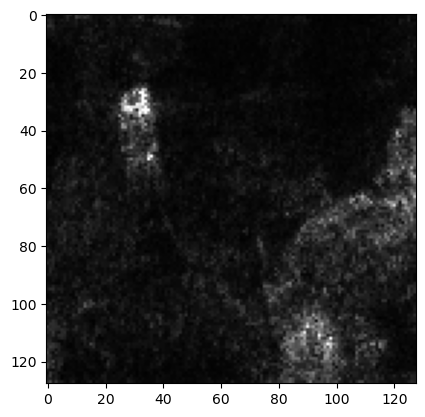

In [88]:
image_size = 128
filename = "/home/jovyan/data/ATRNet-STAR_annotations/SOC_40classes_80_20_split.npz"
annotations_path = "/home/jovyan/data/ATRNet-STAR_annotations/SOC_40classes_annotations.json"
data = get_data_ATRNetSTARSplit(image_size, filename, annotations_path)

print(data[1])

plt.imshow(data.get_test(1)[0], cmap='grey')
plt.show()


In [7]:
def classification_accuracy(image_size=32, k=7, runs=100, split="filename", annotations_path="path", list_data="path"):
    
    data = get_data_ATRNetSTARSplit(image_size, split, annotations_path)

    print(f"Classification accuracy based on kNN with ncc with image size {image_size}, {k} neighbours, with split {split.split("/")[-1]} over {runs} runs")
    num_correct_types = 0
    num_correct_subclasses = 0
    num_correct_classes = 0

    build = np.load(list_data)
    testSample = build["testSample"]
    print("Done w testSample")
    class_names = build["class_names"]
    print("Done w class_names")
    subclass_names = build["subclass_names"]
    print("Done w subclass_names")
    type_names = build["type_names"]
    print("Done w type_names")
    
    for i in range(runs):
        index1 = np.random.randint(data.get_test_len())
        
        unseen_image = data.get_test(index1)[0]
        unseen_class = data.get_test(index1)[1]
        unseen_subclass = data.get_test(index1)[2]
        unseen_type = data.get_test(index1)[3]

        # index1 = np.random.randint(len(data))
        # unseen_image = testSample[index1]
        # unseen_class = class_names[index1]
        # unseen_subclass = subclass_names[index1]
        # unseen_type = type_names[index1]

        # print(f"Unseen image: {unseen_class} {unseen_subclass} {unseen_type}")
        

        arr = np.ones(len(testSample))
        unseen_img_arr = ImageProducts.linear_ncc_psearch(testSample, unseen_image, arr)
        imgProd_max_index = np.argpartition(unseen_img_arr, -(k+1))[-(k+1):][1:]
        
        # put this in a function later
        class_dict = {}
        subclass_dict = {}
        type_dict = {}
        for index in imgProd_max_index:
            if (class_names[index] in class_dict):
                class_dict[class_names[index]] = class_dict[class_names[index]] + 1
            else:
                class_dict[class_names[index]] = 1
            if (subclass_names[index] in subclass_dict):
                subclass_dict[subclass_names[index]] = subclass_dict[subclass_names[index]] + 1
            else:
                subclass_dict[subclass_names[index]] = 1
            if (type_names[index] in type_dict):
                type_dict[type_names[index]] = type_dict[type_names[index]] + 1
            else:
                type_dict[type_names[index]] = 1
            
        
        predict_class = max(class_dict, key= lambda k: class_dict[k])
        predict_subclass = max(subclass_dict, key= lambda k: subclass_dict[k])
        predict_type = max(type_dict, key= lambda k: type_dict[k])
        # print(f"Predicted class: {predict_class} subclass {predict_subclass} type {predict_type}")

        if (predict_class == unseen_class):
            num_correct_classes += 1
        if (predict_subclass == unseen_subclass):
            num_correct_subclasses += 1
        if (predict_type == unseen_type):
            num_correct_types += 1

    print(f"Class accuracy: {num_correct_classes / runs}")
    print(f"Subclass accuracy: {num_correct_subclasses / runs}")
    print(f"Type accuracy: {num_correct_types / runs}")

In [1]:
def classification_accuracy_by_type(image_size=32, k=7, runs=100, split="filename", annotations_path="path", list_data="path"):
    
    data = get_data_ATRNetSTARSplit(image_size, split, annotations_path)

    TYPES = ["Excelle_GT", "GL8", "CS75_Plus", "Starlight_4500", "Cheetah_CFA6473C", "8228-5", "Arrizo 5", "qq3", "Blazer_1998", "HOWO", "Duolika", "EQ6608LTV", "Forthing_Lingzhi",
            "Tianjin_DFH2200B", "Tianjin_KR230", "J6P", "Jiabao_T51", "BJ1045V9JB5-54", "Wall_poer", "Wall_Voleex_C50", "EV160B", "CA7180A3E", "h5", "N1", "HLF25_II", "Junling", "Patriot", 
            "SY5033XJH", "MKC", "Proud_2009", "V80", "Outlander_2003", "ZL40F", "DeLong_M3000", "DeLong_X3000", "Aochi_1800", "Aochi_Hongrui", "Rongguang_V", "YZK6590XCA", "ZK6120HY1"]

    print(f"Classification accuracy by type based on kNN with ncc with image size {image_size}, {k} neighbours, with split {split.split("/")[-1]} over {runs} runs")

    num_correct_types = 0
    num_correct_subclasses = 0
    num_correct_classes = 0

    build = np.load(list_data)
    testSample = build["testSample"]
    print("Done w testSample")
    class_names = build["class_names"]
    print("Done w class_names")
    subclass_names = build["subclass_names"]
    print("Done w subclass_names")
    type_names = build["type_names"]
    print("Done w type_names")
    
    for type_name in TYPES:
        num_good_runs = 0
        num_correct_types = 0
        while (num_good_runs <= runs):

            index1 = np.random.randint(len(data))
            unseen_image = testSample[index1]
            unseen_type = type_names[index1]

            # print(f"Unseen image: {unseen_class} {unseen_subclass} {unseen_type}")

            # index1 = np.random.randint(data.get_test_len())
            # unseen_image = data.get_test(index1)[0]
            # unseen_type = data.get_test(index1)[3]

            if (unseen_type == type_name):
                num_good_runs += 1

                arr = np.ones(len(testSample))
                unseen_img_arr = ImageProducts.linear_ncc_psearch(testSample, unseen_image, arr)
                imgProd_max_index = np.argpartition(unseen_img_arr, -(k+1))[-(k+1):][1:]
                
                # put this in a function later
                type_dict = {}
                for index in imgProd_max_index:
                    if (type_names[index] in type_dict):
                        type_dict[type_names[index]] = type_dict[type_names[index]] + 1
                    else:
                        type_dict[type_names[index]] = 1
                    
                
                predict_type = max(type_dict, key= lambda k: type_dict[k])
                # print(f"Predicted class: {predict_class} subclass {predict_subclass} type {predict_type}")

                if (predict_type == unseen_type):
                    num_correct_types += 1
        print(f"{type_name} classification accuracy: {num_correct_types / runs}")



def classification_accuracy_by_subclass(image_size=32, k=7, runs=100, split="filename", annotations_path="path", list_data="path"):
    
    data = get_data_ATRNetSTARSplit(image_size, split, annotations_path)

    SUBCLASSES = ["Medium_Car", "Mini_Car", "Shovel_Loader", "Road_Roller", "ECV", "Ambulance", "Forklift", "Mixer_Truck", "Medium_TT", "Heavy_FT", "Light_PV", "Heavy_ST", "Heavy_DT", 
        "Light_DT", "Pickup", "Large_Bus", "Medium_Bus", "Small_Bus", "Medium_SUV", "Compact_SUV", "Large_Car"]

    print(f"Classification accuracy by subclass based on kNN with ncc with image size {image_size}, {k} neighbours, with split {split.split("/")[-1]} over {runs} runs")

    num_correct_subclasses = 0

    build = np.load(list_data)
    testSample = build["testSample"]
    print("Done w testSample")
    class_names = build["class_names"]
    print("Done w class_names")
    subclass_names = build["subclass_names"]
    print("Done w subclass_names")
    type_names = build["type_names"]
    print("Done w type_names")
    
    for subclass_name in SUBCLASSES:
        num_good_runs = 0
        num_correct_subclasses = 0
        while (num_good_runs <= runs):

            index1 = np.random.randint(len(data))
            unseen_image = testSample[index1]
            unseen_subclass = subclass_names[index1]

            # print(f"Unseen image: {unseen_class} {unseen_subclass} {unseen_type}")

            # index1 = np.random.randint(data.get_test_len())
            # unseen_image = data.get_test(index1)[0]
            # unseen_subclass = data.get_test(index1)[2]

            if (unseen_subclass == subclass_name):
                num_good_runs += 1

                arr = np.ones(len(testSample))
                unseen_img_arr = ImageProducts.linear_ncc_psearch(testSample, unseen_image, arr)
                imgProd_max_index = np.argpartition(unseen_img_arr, -(k+1))[-(k+1):][1:]
                
                # put this in a function later
                subclass_dict = {}
                for index in imgProd_max_index:
                    if (subclass_names[index] in subclass_dict):
                        subclass_dict[subclass_names[index]] = subclass_dict[subclass_names[index]] + 1
                    else:
                        subclass_dict[subclass_names[index]] = 1
                    
                predict_subclass = max(subclass_dict, key= lambda k: subclass_dict[k])
                # print(f"Predicted class: {predict_class} subclass {predict_subclass} type {predict_type}")

                if (predict_subclass == unseen_subclass):
                    num_correct_subclasses += 1
        print(f"{subclass_name} classification accuracy: {num_correct_subclasses / runs}")

def classification_accuracy_by_class(image_size=32, k=7, runs=100, split="filename", annotations_path="path", list_data="path"):
    
    data = get_data_ATRNetSTARSplit(image_size, split, annotations_path)

    CLASSES = ["Car", "Truck", "Bus", "Special"]

    print(f"Classification accuracy by class based on kNN with ncc with image size {image_size}, {k} neighbours, with split {split.split("/")[-1]} over {runs} runs")

    num_correct_subclasses = 0

    build = np.load(list_data)
    testSample = build["testSample"]
    print("Done w testSample")
    class_names = build["class_names"]
    print("Done w class_names")
    subclass_names = build["subclass_names"]
    print("Done w subclass_names")
    type_names = build["type_names"]
    print("Done w type_names")
    
    for class_name in CLASSES:
        num_good_runs = 0
        num_correct_classes = 0
        while (num_good_runs <= runs):

            index1 = np.random.randint(len(data))
            unseen_image = testSample[index1]
            unseen_class = class_names[index1]

            # print(f"Unseen image: {unseen_class} {unseen_subclass} {unseen_type}")

            # index1 = np.random.randint(data.get_test_len())
            # unseen_image = data.get_test(index1)[0]
            # unseen_class = data.get_test(index1)[1]

            if (unseen_class == class_name):
                num_good_runs += 1

                arr = np.ones(len(testSample))
                unseen_img_arr = ImageProducts.linear_ncc_psearch(testSample, unseen_image, arr)
                imgProd_max_index = np.argpartition(unseen_img_arr, -(k+1))[-(k+1):][1:]
                
                # put this in a function later
                class_dict = {}
                for index in imgProd_max_index:
                    if (class_names[index] in class_dict):
                        class_dict[class_names[index]] = class_dict[class_names[index]] + 1
                    else:
                        class_dict[class_names[index]] = 1
                    
                predict_class = max(class_dict, key= lambda k: class_dict[k])
                # print(f"Predicted class: {predict_class} subclass {predict_subclass} type {predict_type}")

                if (predict_class == unseen_class):
                    num_correct_classes += 1
        print(f"{class_name} classification accuracy: {num_correct_classes / runs}")

In [9]:
# Do this w everyth with 80/20...

split = "/home/jovyan/data/ATRNet-STAR_annotations/SOC_40classes_80_20_split.npz"
annotations_path = "/home/jovyan/data/ATRNet-STAR_annotations/SOC_40classes_annotations.json"
list_data = "/home/jovyan/data/ATRNet-STAR_annotations/list_data_SOC_40classes_80_20_split.npz"

classification_accuracy(image_size=128, k=7, runs=30, split=split, annotations_path=annotations_path, list_data=list_data)

Classification accuracy based on kNN with ncc with image size 128, 7 neighbours, with split SOC_40classes_80_20_split.npz over 30 runs
Done w testSample
Done w class_names
Done w subclass_names
Done w type_names
Class accuracy: 0.8
Subclass accuracy: 0.5333333333333333
Type accuracy: 0.5


In [19]:
class CustomDatasetATRNetSTARAll(Dataset):
    def __init__(self, filename, transform=None):
        data_list = np.load(filename)
        self.data = data_list["data"]
        self.transform = transform
        

    # Defining the length of the dataset
    def __len__(self):
        return len(self.data)

    # Defining the method to get an item from the dataset
    def __getitem__(self, index):
        data_path = str(self.data[index])
        image = Image.open(data_path)
        image = transforms.functional.to_grayscale(image)
        # Applying the transform
        if self.transform:
            image = self.transform(image)
        
        return image.squeeze().to('cpu').numpy()



def get_data_ATRNetSTARAll(size, filename):
    transform = transforms.Compose([
    transforms.Resize((size, size)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
    ])
    return CustomDatasetATRNetSTARAll(filename, transform)


In [20]:
def mtree_ncc_query_times_sample_size(image_size=128, k=7, runs=100, max_node_size=12, list_data="path", sample_sizes = []):

    print(f"Query times of diff methods based on kNN with ncc with image size {image_size}, {k} neighbours, mtree max node size {max_node_size} over {runs} runs")

    data_list = np.load(list_data)
    data = data_list["testSample"]

            
    avgs_ncc_pfft = []
    avgs_ncc_fft = []
    avgs_ncc_unoptim = []
    avgs_mtree = []
    avgs_mtree_fft = []

    for i in range(len(sample_sizes)):
        
        time_ncc_pfft = 0
        time_ncc_fft = 0
        time_ncc_unoptim = 0
        time_mtree = 0
        time_mtree_fft = 0

        sample_indices = random.sample(range(len(data)), sample_sizes[i])
        testSample = data[sample_indices]
        print("done with testSample")
        # tree = getMTree(testSample, max_node_size)
        tree_fft = getMTreeFFTNumba(testSample, max_node_size)
        

        print(f"Now testing with sample size: {sample_sizes[i]}")
        for j in range(runs):

            index1 = np.random.randint(len(data))
            unseen_image = data[index1]

            start_time = time.perf_counter()
            arr = np.ones(len(testSample))
            unseen_img_arr = ImageProducts.linear_ncc_psearch(testSample, unseen_image, arr)
            imgProd_max_index = np.argpartition(unseen_img_arr, -(k+1))[-(k+1):][1:]
            end_time = time.perf_counter()
            time_ncc_pfft += end_time - start_time
            
            start_time = time.perf_counter()
            arr = np.ones(len(testSample))
            unseen_img_arr = ImageProducts.linear_ncc_search(testSample, unseen_image, arr)
            imgProd_max_index = np.argpartition(unseen_img_arr, -(k+1))[-(k+1):][1:]
            end_time = time.perf_counter()
            time_ncc_fft += end_time - start_time

            # start_time = time.perf_counter()
            # arr = []
            # for j in range(len(testSample)):
            #     result = ImageProducts.ncc_scaled(testSample[j], unseen_image)
            #     arr.append(result)
            
            # unseen_img_arr = np.array(arr)
            # imgProd_max_index = np.argpartition(unseen_img_arr, -(k+1))[-(k+1):]
            # time_ncc_unoptim += end_time - start_time

            # start_time = time.perf_counter()
            # knn = getKNearestNeighbours(tree, unseen_image, k)
            # end_time = time.perf_counter()
            # time_mtree += end_time - start_time

            start_time = time.perf_counter()
            knn = getKNearestNeighbours(tree_fft, unseen_image, k)
            end_time = time.perf_counter()
            time_mtree_fft += end_time - start_time
        
        avg_ncc_pfft = time_ncc_pfft / runs
        avgs_ncc_pfft.append(avg_ncc_pfft)
        print(f"Avg time for ncc pfft: {avg_ncc_pfft}")

        avg_ncc_fft = time_ncc_fft / runs
        avgs_ncc_fft.append(avg_ncc_fft)
        print(f"Avg time for ncc fft: {avg_ncc_fft}")

        # avg_ncc_unoptim = time_ncc_unoptim / runs
        # avgs_ncc_unoptim.append(avg_ncc_unoptim)
        # print(f"Avg time for ncc unoptim: {avg_ncc_unoptim}")

        # avg_mtree = time_mtree / runs
        # avgs_mtree.append(avg_mtree)
        # print(f"Avg time for mtree: {avg_mtree}")

        avg_mtree_fft = time_mtree_fft / runs
        avgs_mtree_fft.append(avg_mtree_fft)
        print(f"Avg time for mtree fft: {avg_mtree_fft}")

    print(avgs_ncc_pfft)
    print(avgs_ncc_fft)
    # print(avgs_ncc_unoptim)
    # print(avgs_mtree)
    print(avgs_mtree_fft)
    with open("/home/jovyan/evaluation/results/test_query_sample_sizes.txt", "w") as file:
        file.write(f"sample_sizes = {sample_sizes}\n")
        file.write(f"avgs_ncc_pfft = {avgs_ncc_pfft}\n")
        file.write(f"avgs_ncc_fft = {avgs_ncc_fft}\n")
        # file.write(f"avgs_ncc_unoptim = {avgs_ncc_unoptim}\n")
        # file.write(f"avgs_mtree = {avgs_mtree}\n")
        file.write(f"avgs_mtree_fft = {avgs_mtree_fft}")
        

def mtree_query_times_max_node_size(image_size=128, k=7, runs=100, max_node_sizes=[], list_data="path", sample_size = 1000):

    print(f"Query times of mtree w {image_size}, {k} neighbours, variable mtree max node size, sample size {sample_size} over {runs} runs")

    data_list = np.load(list_data)
    data = data_list["testSample"]

    # avgs_mtree = []
    avgs_mtree_fft = []
    min_time = 1000
    min_node = 0

    for i in range(len(max_node_sizes)):
    
        time_mtree_fft = 0
        
        sample_indices = random.sample(range(len(data)), sample_size)
        testSample = data[sample_indices]
        print("done with testSample")
        tree_fft = getMTreeFFTNumba(testSample, max_node_sizes[i])
        

        print(f"Now testing with max nod size: {max_node_sizes[i]}")
        for j in range(runs):

            index1 = np.random.randint(len(data))
            unseen_image = data[index1]

            start_time = time.perf_counter()
            knn = getKNearestNeighbours(tree_fft, unseen_image, k)
            end_time = time.perf_counter()
            time_mtree_fft += end_time - start_time
    

        avg_mtree_fft = time_mtree_fft / runs
        avgs_mtree_fft.append(avg_mtree_fft)
        if (avg_mtree_fft < min_time):
            min_time = avg_mtree_fft
            min_node = max_node_sizes[i]
        print(f"Avg time for mtree fft: {avg_mtree_fft}")

    print(avgs_mtree_fft)
    return min_node
    # with open("/home/jovyan/evaluation/results/test_query_max_nod_sizes.txt", "w") as file:
    #     file.write(f"avgs_mtree_fft = {avgs_mtree_fft}")


def mtree_init_times_max_node_size(image_size=128, k=7, runs=100, max_node_sizes=[], list_data="path", sample_size = 1000):

    print(f"Init times of mtree w {image_size}, {k} neighbours, variable mtree max node size, sample size {sample_size} over {runs} runs")

    data_list = np.load(list_data)
    data = data_list["testSample"]

    # avgs_mtree = []
    avgs_mtree_fft = []

    for i in range(len(max_node_sizes)):
    
        time_mtree_fft = 0
        
        print(f"Now testing with max node size: {max_node_sizes[i]}")
        for j in range(runs):
            sample_indices = random.sample(range(len(data)), sample_size)
            testSample = data[sample_indices]

            start_time = time.perf_counter()
            tree_fft = getMTreeFFTNumba(testSample, max_node_sizes[i])
            end_time = time.perf_counter()
            time_mtree_fft += end_time - start_time
    

        avg_mtree_fft = time_mtree_fft / runs
        avgs_mtree_fft.append(avg_mtree_fft)
        print(f"Avg time for mtree fft: {avg_mtree_fft}")

    print(avgs_mtree_fft)
    with open("/home/jovyan/evaluation/results/test_init_max_node_sizes.txt", "w") as file:
        file.write(f"avgs_mtree_fft = {avgs_mtree_fft}")


def mtree_init_times_sample_sizes(image_size=128, k=7, runs=100, max_node_size=12, list_data="path", sample_sizes = []):

    print(f"Init times of mtree w {image_size}, {k} neighbours, max_node_size {max_node_size}, variable sample size over {runs} runs")

    data_list = np.load(list_data)
    data = data_list["testSample"]

    # avgs_mtree = []
    avgs_mtree_fft = []

    for i in range(len(sample_sizes)):
    
        # time_mtree = 0
        time_mtree_fft = 0
        
        print(f"Now testing with sample size: {sample_sizes[i]}")
        for j in range(runs):
            sample_indices = random.sample(range(len(data)), sample_sizes[i])
            testSample = data[sample_indices]

            # start_time = time.perf_counter()
            # tree = getMTree(testSample, max_node_size)
            # end_time = time.perf_counter()
            # time_mtree += end_time - start_time

            start_time = time.perf_counter()
            tree_fft = getMTreeFFTNumba(testSample, max_node_size)
            end_time = time.perf_counter()
            time_mtree_fft += end_time - start_time
    
        # avg_mtree = time_mtree / runs
        # avgs_mtree.append(avg_mtree)
        # print(f"Avg time for mtree: {avgs_mtree}")

        avg_mtree_fft = time_mtree_fft / runs
        avgs_mtree_fft.append(avg_mtree_fft)
        print(f"Avg time for mtree fft: {avg_mtree_fft}")

    # print(avgs_mtree)
    print(avgs_mtree_fft)
    with open("/home/jovyan/evaluation/results/test_init_max_sample_sizes.txt", "w") as file:
        # file.write(f"avgs_mtree = {avgs_mtree}\n")
        file.write(f"avgs_mtree_fft = {avgs_mtree_fft}")


def ncc_unoptim_query_times_sample_size(image_size=128, k=7, runs=100, max_node_size=12, list_data="path", sample_sizes = []):

    print(f"Query times of ncc unoptimised based on kNN with ncc with image size {image_size}, {k} neighbours, mtree max node size {max_node_size} over {runs} runs")

    data_list = np.load(list_data)
    data = data_list["testSample"]

    avgs_ncc_unoptim = []

    for i in range(len(sample_sizes)):
        
        time_ncc_unoptim = 0

        sample_indices = random.sample(range(len(data)), sample_sizes[i])
        testSample = data[sample_indices]
        print("done with testSample")
        

        print(f"Now testing with sample size: {sample_sizes[i]}")
        for j in range(runs):

            index1 = np.random.randint(len(data))
            unseen_image = data[index1]

            start_time = time.perf_counter()
            arr = []
            for j in range(len(testSample)):
                result = ImageProducts.ncc_scaled(testSample[j], unseen_image)
                arr.append(result)
            
            unseen_img_arr = np.array(arr)
            imgProd_max_index = np.argpartition(unseen_img_arr, -(k+1))[-(k+1):]
            end_time = time.perf_counter()
            
            time_ncc_unoptim += end_time - start_time

        avg_ncc_unoptim = time_ncc_unoptim / runs
        avgs_ncc_unoptim.append(avg_ncc_unoptim)
        print(f"Avg time for ncc unoptim: {avg_ncc_unoptim}")

    print(avgs_ncc_unoptim)

    with open("/home/jovyan/evaluation/results/test_ncc_unoptim_query_sample_sizes.txt", "w") as file:
        file.write(f"sample_sizes = {sample_sizes}\n")
        file.write(f"avgs_ncc_unoptim = {avgs_ncc_unoptim}")


def mtree_ncc_query_times_image_size(image_sizes=[], k=7, runs=30, max_node_size=25, split_path="", sample_size = 1000):

    print(f"Query times of diff methods based on kNN with ncc with variable image size, {k} neighbours, mtree max node size {max_node_size} over {runs} runs")

            
    avgs_ncc_pfft = []
    avgs_ncc_fft = []
    avgs_ncc_unoptim = []
    avgs_mtree = []
    avgs_mtree_fft = []

    for i in range(len(image_sizes)):

        dataset = get_data_ATRNetSTARAll(image_sizes[i], split_path)
        data = np.array([item for item in dataset])
    
        
        time_ncc_pfft = 0
        time_ncc_fft = 0
        time_ncc_unoptim = 0
        time_mtree = 0
        time_mtree_fft = 0

        sample_indices = random.sample(range(len(data)), sample_size)
        testSample = data[sample_indices]
        print("done with testSample")
        # tree = getMTree(testSample, max_node_size)
        tree_fft = getMTreeFFTNumba(testSample, max_node_size)
        

        print(f"Now testing with image size: {image_sizes[i]}")
        for j in range(runs):

            index1 = np.random.randint(len(data))
            unseen_image = data[index1]

            start_time = time.perf_counter()
            arr = np.ones(len(testSample))
            unseen_img_arr = ImageProducts.linear_ncc_psearch(testSample, unseen_image, arr)
            imgProd_max_index = np.argpartition(unseen_img_arr, -(k+1))[-(k+1):][1:]
            end_time = time.perf_counter()
            time_ncc_pfft += end_time - start_time
            
            start_time = time.perf_counter()
            arr = np.ones(len(testSample))
            unseen_img_arr = ImageProducts.linear_ncc_search(testSample, unseen_image, arr)
            imgProd_max_index = np.argpartition(unseen_img_arr, -(k+1))[-(k+1):][1:]
            end_time = time.perf_counter()
            time_ncc_fft += end_time - start_time

            # start_time = time.perf_counter()
            # arr = []
            # for j in range(len(testSample)):
            #     result = ImageProducts.ncc_scaled(testSample[j], unseen_image)
            #     arr.append(result)
            
            # unseen_img_arr = np.array(arr)
            # imgProd_max_index = np.argpartition(unseen_img_arr, -(k+1))[-(k+1):]
            # time_ncc_unoptim += end_time - start_time

            # start_time = time.perf_counter()
            # knn = getKNearestNeighbours(tree, unseen_image, k)
            # end_time = time.perf_counter()
            # time_mtree += end_time - start_time

            start_time = time.perf_counter()
            knn = getKNearestNeighbours(tree_fft, unseen_image, k)
            end_time = time.perf_counter()
            time_mtree_fft += end_time - start_time
        
        avg_ncc_pfft = time_ncc_pfft / runs
        avgs_ncc_pfft.append(avg_ncc_pfft)
        print(f"Avg time for ncc pfft: {avg_ncc_pfft}")

        avg_ncc_fft = time_ncc_fft / runs
        avgs_ncc_fft.append(avg_ncc_fft)
        print(f"Avg time for ncc fft: {avg_ncc_fft}")

        # avg_ncc_unoptim = time_ncc_unoptim / runs
        # avgs_ncc_unoptim.append(avg_ncc_unoptim)
        # print(f"Avg time for ncc unoptim: {avg_ncc_unoptim}")

        # avg_mtree = time_mtree / runs
        # avgs_mtree.append(avg_mtree)
        # print(f"Avg time for mtree: {avg_mtree}")

        avg_mtree_fft = time_mtree_fft / runs
        avgs_mtree_fft.append(avg_mtree_fft)
        print(f"Avg time for mtree fft: {avg_mtree_fft}")

    print(avgs_ncc_pfft)
    print(avgs_ncc_fft)
    # print(avgs_ncc_unoptim)
    # print(avgs_mtree)
    print(avgs_mtree_fft)
    with open("/home/jovyan/evaluation/results/test_query_image_sizes.txt", "w") as file:
        file.write(f"image_sizes = {image_sizes}\n")
        file.write(f"avgs_ncc_pfft = {avgs_ncc_pfft}\n")
        file.write(f"avgs_ncc_fft = {avgs_ncc_fft}\n")
        # file.write(f"avgs_ncc_unoptim = {avgs_ncc_unoptim}\n")
        # file.write(f"avgs_mtree = {avgs_mtree}\n")
        file.write(f"avgs_mtree_fft = {avgs_mtree_fft}")

def mtree_init_times_image_size(image_sizes=[], k=7, runs=30, max_node_size=25, split_path="", sample_size = 1000):

    print(f"Init times of mtree based on kNN with ncc with variable image size, {k} neighbours, mtree max node size {max_node_size} over {runs} runs")

            
    avgs_mtree_fft = []


    for i in range(len(image_sizes)):

        dataset = get_data_ATRNetSTARAll(image_sizes[i], split_path)
        data = np.array([item for item in dataset])
    
        time_mtree_fft = 0

        sample_indices = random.sample(range(len(data)), sample_size)
        testSample = data[sample_indices]
        print("done with testSample")
        

        print(f"Now testing with image size: {image_sizes[i]}")
        for j in range(runs):
            start_time = time.perf_counter()
            tree_fft = getMTreeFFTNumba(testSample, max_node_size)
            end_time = time.perf_counter()
            time_mtree_fft += end_time - start_time

        avg_mtree_fft = time_mtree_fft / runs
        avgs_mtree_fft.append(avg_mtree_fft)
        print(f"Avg time for mtree fft: {avg_mtree_fft}")

    print(avgs_mtree_fft)

    with open("/home/jovyan/evaluation/results/test_init_image_sizes.txt", "w") as file:
        file.write(f"image_sizes = {image_sizes}\n")
        file.write(f"avgs_mtree_fft = {avgs_mtree_fft}")

In [13]:
list_data = "/home/jovyan/data/ATRNet-STAR_annotations/list_data_all.npz"
split_path = "/home/jovyan/data/ATRNet-STAR_annotations/all_filepaths.npz"

# with max node size 37 from sample size 5k it at least beats the ncc fft by like 0.05s TTTT omg and it loses again at 10k UGH .
# print(np.load(list_data)["testSample"].shape)

max_node_sizes = list(np.arange(61))[4:]
# print(max_node_sizes)
min =mtree_query_times_max_node_size(image_size=128, k=7, runs=30, max_node_sizes=max_node_sizes, list_data=list_data, sample_size = 1000)
# min = mtree_query_times_max_node_size(image_size=128, k=7, runs=30, max_node_sizes=max_node_sizes, list_data=list_data, sample_size = 100)
print(min)


Query times of mtree w 128, 7 neighbours, variable mtree max node size, sample size 1000 over 30 runs
done with testSample
Now testing with max nod size: 4
Avg time for mtree fft: 0.725062930289035
done with testSample
Now testing with max nod size: 5
Avg time for mtree fft: 0.7037531054811552
done with testSample
Now testing with max nod size: 6
Avg time for mtree fft: 0.648886060132645
done with testSample
Now testing with max nod size: 7
Avg time for mtree fft: 0.618746844609268
done with testSample
Now testing with max nod size: 8
Avg time for mtree fft: 0.6396698549467449
done with testSample
Now testing with max nod size: 9
Avg time for mtree fft: 0.6134348505254213
done with testSample
Now testing with max nod size: 10
Avg time for mtree fft: 0.6214043123958012
done with testSample
Now testing with max nod size: 11
Avg time for mtree fft: 0.8181839826283976
done with testSample
Now testing with max nod size: 12
Avg time for mtree fft: 0.5998572603799402
done with testSample
Now 

In [15]:
def plot_data_max_node_query(x_axis="", title="", filename="", varied_arr=[], data=[]):
    data_mtree_init = []
    for i in range(len(varied_arr)):
        data_mtree_init.append([varied_arr[i], data[i]])

    data_mtree_init = np.array(data_mtree_init)

    x_mtree_init, y_mtree_init = data_mtree_init.T

    plt.plot(x_mtree_init, y_mtree_init, label = f"mtree query", linestyle="-")
    plt.legend()
    plt.xlabel(x_axis)
    plt.ylabel("Runtime (s)")
    plt.title(title)
    # note its over 3 runs
    plt.tight_layout()
    plt.savefig(filename, bbox_inches='tight', dpi=1000)

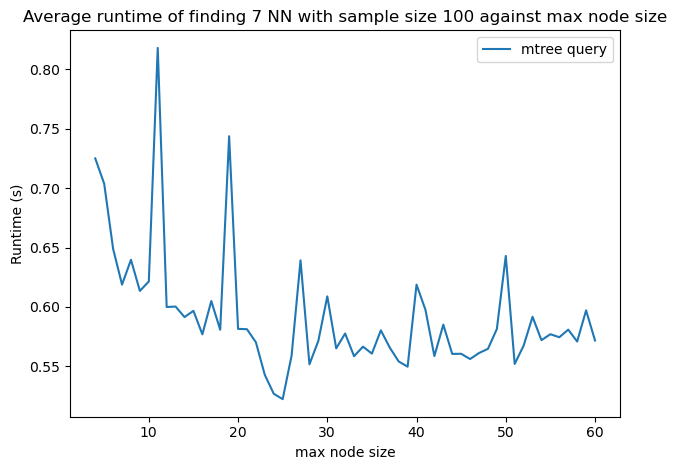

In [16]:
mtree_data = [0.725062930289035, 0.7037531054811552, 0.648886060132645, 0.618746844609268, 0.6396698549467449, 0.6134348505254213, 0.6214043123958012, 0.8181839826283976, 0.5998572603799402, 0.6002516879932955, 0.5913838393132512, 0.5966457396435241, 0.5768559851838897, 0.6048893684443707, 0.5807189660922935, 0.7437571340085317, 0.5814665307678903, 0.5811646994746601, 0.5701398869045079, 0.5426731905356671, 0.5267790214934697, 0.5222330360440537, 0.5589521776419133, 0.6392089224498098, 0.551588378683664, 0.5713954269886017, 0.6088508217440297, 0.5649976735391343, 0.5775652576393138, 0.5584259866581609, 0.5664701420813799, 0.5606103637333338, 0.580204312169614, 0.5656760389528548, 0.5539871407905593, 0.5496048925677315, 0.6187110900646076, 0.5974964648950845, 0.5585179638117552, 0.584993886644952, 0.5603587300439055, 0.5604661263059825, 0.5560414492851123, 0.5610987125430256, 0.5646205369150266, 0.5813168961089105, 0.642927580854545, 0.5518888479021068, 0.5673044215499734, 0.5916150703871002, 0.5719472602397825, 0.576945099940834, 0.5744023642114674, 0.5807990731283401, 0.5707855086540803, 0.597041737458979, 0.5716482879516358]
varied_arr = max_node_sizes

plot_data_max_node_query(x_axis="max node size", title="Average runtime of finding 7 NN with sample size 100 against max node size", filename="/home/jovyan/evaluation/results/query_max_node_size.png", varied_arr=varied_arr, data=mtree_data)

In [ ]:
# 4 to 60. max is 25 for both
[0.725062930289035, 0.7037531054811552, 0.648886060132645, 0.618746844609268, 0.6396698549467449, 0.6134348505254213, 0.6214043123958012, 0.8181839826283976, 0.5998572603799402, 0.6002516879932955, 0.5913838393132512, 0.5966457396435241, 0.5768559851838897, 0.6048893684443707, 0.5807189660922935, 0.7437571340085317, 0.5814665307678903, 0.5811646994746601, 0.5701398869045079, 0.5426731905356671, 0.5267790214934697, 0.5222330360440537, 0.5589521776419133, 0.6392089224498098, 0.551588378683664, 0.5713954269886017, 0.6088508217440297, 0.5649976735391343, 0.5775652576393138, 0.5584259866581609, 0.5664701420813799, 0.5606103637333338, 0.580204312169614, 0.5656760389528548, 0.5539871407905593, 0.5496048925677315, 0.6187110900646076, 0.5974964648950845, 0.5585179638117552, 0.584993886644952, 0.5603587300439055, 0.5604661263059825, 0.5560414492851123, 0.5610987125430256, 0.5646205369150266, 0.5813168961089105, 0.642927580854545, 0.5518888479021068, 0.5673044215499734, 0.5916150703871002, 0.5719472602397825, 0.576945099940834, 0.5744023642114674, 0.5807990731283401, 0.5707855086540803, 0.597041737458979, 0.5716482879516358]

# 5 to 40
[0.070487150689587, 0.07256089289827893, 0.07407869189046323, 0.07051757913238059, 0.06885492148964355, 0.06963022660153607, 0.07124243145808577, 0.06567341204887876, 0.05940019638898472, 0.0676652840571478, 0.08140255967931201, 0.059248986498763166, 0.06250119744800031, 0.05861995202333977, 0.05597544115347167, 0.05671816123649478, 0.05837245679770907, 0.05678480569428454, 0.05644277653191239, 0.05594597005595763, 0.055371736634212236, 0.056529672265363234, 0.06745421915159872, 0.07514918510181208, 0.05773736654470364, 0.06254692213454595, 0.0699877317296341, 0.07659948399911325, 0.07136243373000374, 0.05737299322305868, 0.06401508589430402, 0.05517622525803745, 0.05815047712530941, 0.07950161831298222, 0.06338718918462595, 0.05677823741765072]

In [ ]:
import psutil

def my_function():
    print("Running on limited CPUs")

if __name__ == "__main__":
    data = get_data(image_size)
    
    sample_indices = random.sample(range(len(data)), sample_sizes[i])
    sampled_test_data = Subset(data, sample_indices)
    testSample = np.array(sampled_test_data)

    index1 = np.random.randint(len(data))
    unseen_image = data[index1][0]
    # Get the current process
    p = psutil.Process()
    # Limit the process to use only CPU 0 and 1
    p.cpu_affinity([i for i in range(20)])

    start_time = time.perf_counter()
    arr = np.ones(len(testSample))
    unseen_img_arr = ImageProducts.linear_ncc_psearch(testSample, unseen_image, arr)
    imgProd_max_index = np.argpartition(unseen_img_arr, -(k+1))[-(k+1):][1:]
    end_time = time.perf_counter()
    print(end_time - start_time)
    # my_function()

# SARDET


In [123]:
import sys
import os
path = os.path.abspath("../")
sys.path.append(path)

import torch
from torch.utils.data import Dataset, Subset
from torchvision import datasets, transforms

import matplotlib.pyplot as plt
import numpy as np
import numba as nb
from numba import prange
import math
import pandas as pd
import random

from line_profiler import profile

import src.helpers.MetricUtilities as metrics
import src.data_processing.ImageProducts as ImageProducts


from mtree.mtree import MTree
import mtree.mtree as mtree

import glob
from PIL import Image
import cv2

import time

import json
def getKNearestNeighbours(tree, point, k):
    l = tree.search(point, k)
    imgs = list(l)
    return imgs

def getMTree(data, k):
    # k: desired number of nearest neighbours
    tree = MTree(metrics.distance, max_node_size=k)
    tree.add_all(data)
    return tree

def getMTreeFFT(data, k):
    # k: desired number of nearest neighbours
    tree = MTree(metrics.dist_fft, max_node_size=k)
    tree.add_all(data)
    return tree

def getMTreeFFTNumba(data, k):
    # k: desired number of nearest neighbours
    tree = MTree(metrics.dist_fft_numba, max_node_size=k)
    tree.add_all(data)
    return tree


@nb.njit(parallel=True, cache=True)
def linear_ncc_psearch(testSample, unseen_image, arr):
    for i in prange(len(testSample)):
        arr[i] = ImageProducts.ncc_fft_numba(testSample[i], unseen_image)

    return arr

@nb.njit(cache=True)
def linear_ncc_search(testSample, unseen_image, arr):
    for i in range(len(testSample)):
        arr[i] = ImageProducts.ncc_fft_numba(testSample[i], unseen_image)

    return arr



# TODO look at train/val/test.json format and extract out the category id and the id to class mapping at the v end.
class CustomDatasetSARDet_100k(Dataset):
    def __init__(self, transform=None):
        self.transform = transform

        self.imgs_path = "/home/jovyan/data/SARDet_100k/SARDet_100K/JPEGImages/"
        file_list = glob.glob(self.imgs_path + "*")
        self.data = []

        # with open("../data/SARDet_100k/SARDet_100K/mapping.json") as annotations:
        #     mappings = json.load(annotations)

        for dir_path in file_list:
            for img_path in glob.glob(dir_path + "/*.png"):
                # self.data.append([img_path, mappings[img_path.split("/")[-1]]])
                self.data.append([img_path, "yippee"])
            for img_path in glob.glob(dir_path + "/*.jpg"):
                # self.data.append([img_path, mappings[img_path.split("/")[-1]]])
                self.data.append([img_path, "yippee"])
        

    # Defining the length of the dataset
    def __len__(self):
        return len(self.data)

    # Defining the method to get an item from the dataset
    def __getitem__(self, index):
        data_path = self.data[index]
        image = Image.open(data_path[0])
        image = transforms.functional.to_grayscale(image)
        # class_id = self.class_map[data_path[1]]
        class_id = data_path[1]
        # Applying the transform
        if self.transform:
            image = self.transform(image)
        
        return image.squeeze().to('cpu').numpy(), class_id

def get_data_SARDet_100k(size):
    transform = transforms.Compose([
    transforms.Resize((size, size)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
    ])
    return CustomDatasetSARDet_100k(transform)


def mtree_ncc_query_sample_size(max_node_size=12, image_size=32, k=7, runs=2, sample_sizes=[1]):
    total_time_ncc = 0
    total_time_ncc_parallel = 0
    total_time_ncc_njit = 0
    total_time_mtree_njit = 0
    total_time_mtree = 0
    
    avg_times_ncc = []
    avg_times_ncc_parallel = []
    avg_times_ncc_njit = []
    avg_times_mtree_njit = []
    avg_times_mtree = []

    data = get_data_SARDet_100k(image_size)

    print(f"Average runtime of querying mtrees and nccs for {k} NN over {runs} runs with image size {image_size} and max node size {max_node_size} and variable sample size")
    for i in range(len(sample_sizes)):
        print(f"NOW TRYING sample size: {sample_sizes[i]}")
        total_time_ncc = 0
        total_time_ncc_parallel = 0
        total_time_ncc_njit = 0
        total_time_mtree_njit = 0
        total_time_mtree = 0

        sample_indices = random.sample(range(len(data)), sample_sizes[i])
        sampled_test_data = Subset(data, sample_indices)

        testSample = [item[0] for item in sampled_test_data]
        

        # tree = getMTree(testSample, max_node_size)
        tree_numba = getMTreeFFTNumba(testSample, max_node_size)

        # trans = transforms.Compose([transforms.Resize(img_sizes[i])])
        # t_MNIST_data = trans(MNIST_data)

        # for img in MNIST_data:
        #     img = trans(img)

        for _ in range(runs):
            index1 = np.random.randint(len(data))
            #input1=input_dataset[index1][0].squeeze().to('cpu')
            unseen_image = data[index1][0]

            # start_time = time.perf_counter()
            # arr = []
            # for j in range(len(testSample)):
            #     result = ImageProducts.ncc_scaled(testSample[j], unseen_image)
            #     arr.append(result)
            
            # unseen_img_arr = np.array(arr)
            # #print(unseen_img_arr)
            # imgProd_max_index = np.argpartition(unseen_img_arr, -(k+1))[-(k+1):]
            # end_time = time.perf_counter()

            # total_time_ncc += end_time - start_time

            # start_time = time.perf_counter()
            # arr = np.ones(len(testSample))
            # unseen_img_arr = linear_ncc_psearch(testSample, unseen_image, arr)
            # imgProd_max_index = np.argpartition(unseen_img_arr, -(k+1))[-(k+1):]
            # end_time = time.perf_counter()

            # total_time_ncc_parallel += end_time - start_time

            start_time = time.perf_counter()
            arr = np.ones(len(testSample))
            unseen_img_arr = linear_ncc_search(testSample, unseen_image, arr)
            imgProd_max_index = np.argpartition(unseen_img_arr, -(k+1))[-(k+1):]
            end_time = time.perf_counter()

            total_time_ncc_njit += end_time - start_time

            start_time = time.perf_counter()
            imgs = getKNearestNeighbours(tree_numba, unseen_image, k+1)
            end_time = time.perf_counter()
            total_time_mtree_njit += end_time - start_time

            # start_time = time.perf_counter()
            # imgs = getKNearestNeighbours(tree, unseen_image, k+1)
            # end_time = time.perf_counter()
            # total_time_mtree += end_time - start_time

        # avg_ncc = total_time_ncc / runs
        # avg_ncc_parallel = total_time_ncc_parallel / runs
        avg_ncc_njit = total_time_ncc_njit / runs
        avg_mtree_njit = total_time_mtree_njit / runs
        # avg_mtree = total_time_mtree / runs
        
        # avg_times_ncc.append(avg_ncc)
        # avg_times_ncc_parallel.append(avg_ncc_parallel)
        avg_times_ncc_njit.append(avg_ncc_njit)
        avg_times_mtree_njit.append(avg_mtree_njit)
        # avg_times_mtree.append(avg_mtree)
        

        # with open("./test_mtree_query_sample_sizes_avg_times_ncc_.txt", "w") as file:
        #      file.write(f"avg times: {str(avg_times_ncc)}")
        
        # with open("test_mtree_query_sample_sizes_avg_times_mtree_.txt", "w") as file:
        #      file.write(f"avg times: {str(avg_times_mtree)}")

        # print(f"Average runtime of unoptimised ncc search: {avg_ncc:.6f} seconds")
        # print(f"Average runtime of ncc parallel njit search: {avg_ncc_parallel:.6f} seconds")
        print(f"Average runtime of ncc njit search: {avg_ncc_njit:.6f} seconds")
        print(f"Average runtime of mtree njit search: {avg_mtree_njit:.6f} seconds")
        # print(f"Average runtime of unoptimised mtree search: {avg_mtree:.6f} seconds")
    
    # print(avg_times_ncc)
    # print(avg_times_ncc_parallel)
    print(avg_times_ncc_njit)
    print(avg_times_mtree_njit)
    # print(avg_times_mtree)


In [ ]:
sample_sizes = [100, 1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000]
mtree_ncc_query_sample_size(max_node_size=39, image_size=128, k=7, runs=30, sample_sizes=sample_sizes)

Average runtime of querying mtrees and nccs for 7 NN over 30 runs with image size 128 and max node size 39 and variable sample size
NOW TRYING sample size: 100
Average runtime of ncc njit search: 0.069124 seconds
Average runtime of mtree njit search: 0.046550 seconds
NOW TRYING sample size: 1000
Average runtime of ncc njit search: 0.562680 seconds
Average runtime of mtree njit search: 0.453381 seconds
NOW TRYING sample size: 2000
Average runtime of ncc njit search: 1.167499 seconds
Average runtime of mtree njit search: 0.840686 seconds
NOW TRYING sample size: 3000
Average runtime of ncc njit search: 1.751379 seconds
Average runtime of mtree njit search: 1.499265 seconds
NOW TRYING sample size: 4000
Average runtime of ncc njit search: 2.351256 seconds
Average runtime of mtree njit search: 1.983506 seconds
NOW TRYING sample size: 5000
Average runtime of ncc njit search: 3.005439 seconds
Average runtime of mtree njit search: 2.481835 seconds
NOW TRYING sample size: 6000


# plotting

In [6]:
def plot_data_max_node_query(x_axis="", title="", filename="", varied_arr=[], data=[]):
    data_mtree_init = []
    for i in range(len(varied_arr)):
        data_mtree_init.append([varied_arr[i], data[i]])

    data_mtree_init = np.array(data_mtree_init)

    x_mtree_init, y_mtree_init = data_mtree_init.T

    plt.plot(x_mtree_init, y_mtree_init, label = f"mtree init", linestyle="-")
    plt.legend()
    plt.xlabel(x_axis)
    plt.ylabel("Runtime (s)")
    plt.title(title)
    # note its over 3 runs
    plt.tight_layout()
    # plt.show()
    plt.savefig(filename, bbox_inches='tight', dpi=1000)


def plot_data_mtree_ncc(x_axis="", title="", filename="", varied_arr=[], data1=[], data2=[], data3=[], max_node_size=25):
    data_pncc = []
    data_ncc = []
    data_mtree = []
    
    for i in range(len(varied_arr)):
        data_pncc.append([varied_arr[i], data1[i]])
        data_ncc.append([varied_arr[i], data2[i]])
        data_mtree.append([varied_arr[i], data3[i]])

    # print(data_ncc)
    # print(data_mtree)
    data_pncc = np.array(data_pncc)
    data_ncc = np.array(data_ncc)
    data_mtree = np.array(data_mtree)

    x_pncc, y_pncc = data_pncc.T
    x_ncc, y_ncc = data_ncc.T
    x_mtree, y_mtree = data_mtree.T

    plt.plot(x_pncc, y_pncc, label = "pNCC", linestyle="-")
    plt.plot(x_ncc, y_ncc, label = "NCC", linestyle="--")
    plt.plot(x_mtree, y_mtree, label = f"mtree search, node size {max_node_size}", linestyle=":")
    plt.legend()
    plt.xlabel(x_axis)  # Title for the x-axis
    plt.ylabel("Runtime (s)")  # Title for the y-axis
    plt.title(title)
    plt.tight_layout()
    plt.show()
    #plt.savefig(filename, bbox_inches='tight', dpi=1000)

def plot_data_scale_resolutions(x_axis="", title="", filename="", varied_arr=[], data1=[], data2=[], data3=[], data4=[]):
    data_ATRNET = []
    data_IMDB = []
    data_MSTAR = []
    data_SARDET = []
    
    for i in range(len(varied_arr)):
        data_ATRNET.append([varied_arr[i], data1[i]])
        data_IMDB.append([varied_arr[i], data2[i]])
        data_MSTAR.append([varied_arr[i], data3[i]])
        data_SARDET.append([varied_arr[i], data4[i]])

    # print(data_ncc)
    # print(data_mtree)
    data_ATRNET = np.array(data_ATRNET)
    data_IMDB = np.array(data_IMDB)
    data_MSTAR = np.array(data_MSTAR)
    data_SARDET = np.array(data_SARDET)

    x_ATRNET, y_ATRNET = data_ATRNET.T
    x_IMDB, y_IMDB = data_IMDB.T
    x_MSTAR, y_MSTAR = data_MSTAR.T
    x_SARDET, y_SARDET = data_SARDET.T

    plt.plot(x_ATRNET, y_ATRNET, label = "ATRNET", linestyle="-")
    plt.plot(x_IMDB, y_IMDB, label = "IMDB", linestyle="--")
    plt.plot(x_MSTAR, y_MSTAR, label = f"MSTAR", linestyle=":")
    plt.plot(x_SARDET, y_SARDET, label = f"SARDET", linestyle="-.")
    plt.legend()
    plt.xlabel(x_axis)  # Title for the x-axis
    plt.ylabel("Estimated ID")  # Title for the y-axis
    plt.title(title)
    plt.tight_layout()
    #plt.show()
    plt.savefig(filename, bbox_inches='tight', dpi=1000)

def plot_data_pncc_cores(x_axis="", title="", filename="", varied_arr=[], data1=[], data2=[]):
    data_pncc = []
    data_ncc = []
    
    for i in range(len(varied_arr)):
        data_pncc.append([varied_arr[i], data1[i]])
        data_ncc.append([varied_arr[i], data2[i]])

    # print(data_ncc)
    # print(data_mtree)
    data_pncc = np.array(data_pncc)
    data_ncc = np.array(data_ncc)

    x_pncc, y_pncc = data_pncc.T
    x_ncc, y_ncc = data_ncc.T

    plt.plot(x_pncc, y_pncc, label = "pNCC", linestyle="-")
    plt.plot(x_ncc, y_ncc, label = "NCC", linestyle="--")
    plt.legend()
    plt.xlabel(x_axis)  # Title for the x-axis
    plt.ylabel("Runtime (s)")  # Title for the y-axis
    plt.title(title)
    plt.tight_layout()
    plt.savefig(filename, bbox_inches='tight', dpi=1000)





def plot_perf_compaison(x_axis="", title="", filename="", varied_arr=[], data1=[], data2=[], data3=[], data4=[]):
    data_ATRNET = []
    data_IMDB = []
    data_MSTAR = []
    data_SARDET = []
    
    for i in range(len(varied_arr)):
        data_ATRNET.append([varied_arr[i], data1[i]])
        data_IMDB.append([varied_arr[i], data2[i]])
        data_MSTAR.append([varied_arr[i], data3[i]])
        data_SARDET.append([varied_arr[i], data4[i]])

    # print(data_ncc)
    # print(data_mtree)
    data_ATRNET = np.array(data_ATRNET)
    data_IMDB = np.array(data_IMDB)
    data_MSTAR = np.array(data_MSTAR)
    data_SARDET = np.array(data_SARDET)

    x_ATRNET, y_ATRNET = data_ATRNET.T
    x_IMDB, y_IMDB = data_IMDB.T
    x_MSTAR, y_MSTAR = data_MSTAR.T
    x_SARDET, y_SARDET = data_SARDET.T

    plt.plot(x_ATRNET, y_ATRNET, label = "ATRNET", linestyle="-")
    plt.plot(x_IMDB, y_IMDB, label = "IMDB", linestyle="--")
    plt.plot(x_MSTAR, y_MSTAR, label = f"MSTAR", linestyle=":")
    plt.plot(x_SARDET, y_SARDET, label = f"SARDET", linestyle="-.")
    plt.legend()
    plt.xlabel(x_axis)  # Title for the x-axis
    plt.ylabel("Runtime (s)")  # Title for the y-axis
    plt.title(title)
    plt.tight_layout()
    plt.show()
    #plt.savefig(filename, bbox_inches='tight', dpi=1000)

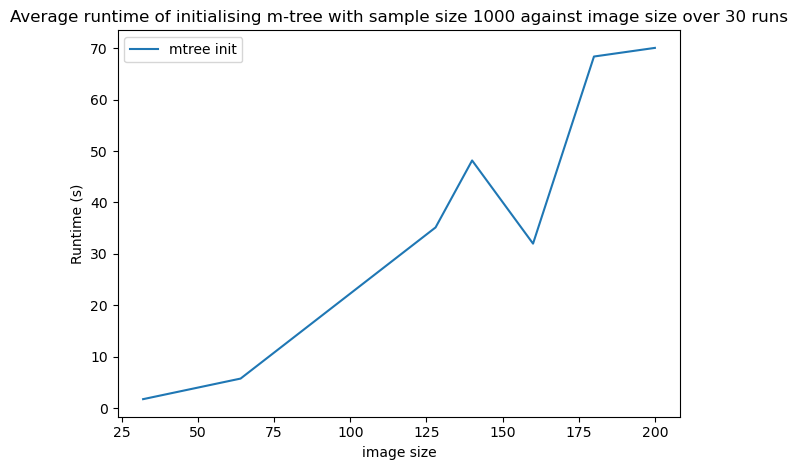

In [76]:
image_sizes = [32, 64, 128, 140, 160, 180, 200]
# image_sizes = [32**2, 64**2, 128**2, 140**2, 160**2, 180**2, 200**2]
avgs_mtree_fft = [1.7351142049301416, 5.739906990900636, 35.14103743660574, 48.16948829362324, 31.991825342659528, 68.39099154097494, 70.06929444218986]

plot_data_max_node_query(x_axis="image size", title="Average runtime of initialising m-tree with sample size 1000 against image size over 30 runs", filename="/home/jovyan/evaluation/results/ATRNET_test_init_image_sizes.png", varied_arr=image_sizes, data=avgs_mtree_fft)

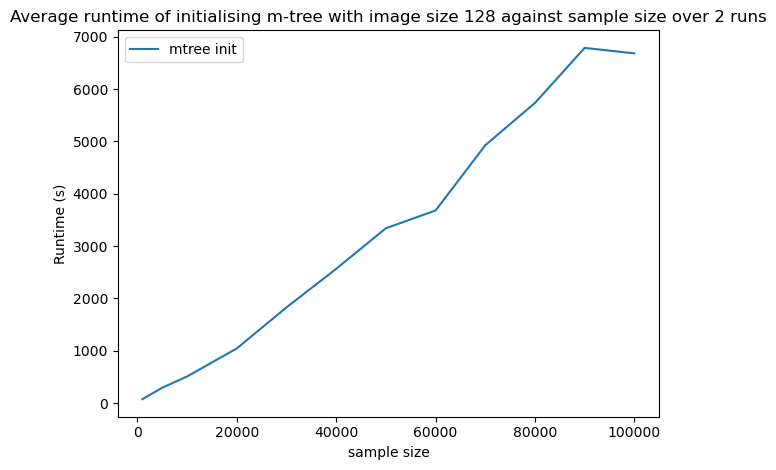

In [77]:
sample_sizes = [1000, 5000, 10000, 20000, 30000, 40000, 50000, 60000, 70000, 80000, 90000, 100000]
avgs_mtree_fft = [75.49970278551336, 294.28758062107954, 509.53797336597927, 1044.6455672959564, 1829.269034767989, 2565.4896710524336, 3340.9405758810462, 3680.1977933344897, 4926.651265969966, 5734.713486509863, 6786.601447692607, 6681.795989576494]
# run w 80k one more time

plot_data_max_node_query(x_axis="sample size", title="Average runtime of initialising m-tree with image size 128 against sample size over 2 runs", filename="/home/jovyan/evaluation/results/ATRNET_test_init_sample_sizes.png", varied_arr=sample_sizes, data=avgs_mtree_fft)

In [ ]:
list_data = "/home/jovyan/data/ATRNet-STAR_annotations/list_data_all.npz"

data_list = np.load(list_data)
data = data_list["testSample"]

sample_indices = random.sample(range(len(data)), 1000)
testSample = data[sample_indices]

In [61]:
# Just to init

index1 = np.random.randint(len(data))
unseen_image = data[index1]

avg_pncc = 0
avg_ncc = 0


start_time = time.perf_counter()
arr = np.ones(len(testSample))
unseen_img_arr = ImageProducts.linear_ncc_psearch(testSample, unseen_image, arr)
imgProd_max_index = np.argpartition(unseen_img_arr, -(k+1))[-(k+1):][1:]
end_time = time.perf_counter()
avg_pncc += end_time - start_time

In [62]:
k=7
runs = 100

index1 = np.random.randint(len(data))
unseen_image = data[index1]

avg_pncc = 0
avg_ncc = 0

for i in range(runs):
    start_time = time.perf_counter()
    arr = np.ones(len(testSample))
    unseen_img_arr = ImageProducts.linear_ncc_psearch(testSample, unseen_image, arr)
    imgProd_max_index = np.argpartition(unseen_img_arr, -(k+1))[-(k+1):][1:]
    end_time = time.perf_counter()
    avg_pncc += end_time - start_time

    start_time = time.perf_counter()
    arr = np.ones(len(testSample))
    unseen_img_arr = ImageProducts.linear_ncc_search(testSample, unseen_image, arr)
    imgProd_max_index = np.argpartition(unseen_img_arr, -(k+1))[-(k+1):][1:]
    end_time = time.perf_counter()
    avg_ncc += end_time - start_time

avg_pncc = avg_pncc / runs
avg_ncc = avg_ncc / runs

print(f"parallel: {avg_pncc}")
print(f"for non parallel: {avg_ncc}")
# my_function()

parallel: 0.1602316380175762
for non parallel: 0.5885769659420476


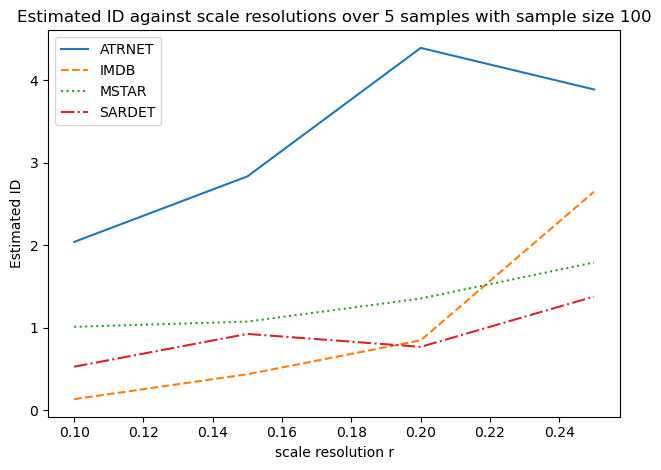

In [95]:
# r = [0.05, 0.1, 0.15, 0.2, 0.25, 0.3]
r = [0.1, 0.15, 0.2, 0.25]
ATRNET = [np.float64(2.0394000302223434), np.float64(2.834224591130716), np.float64(4.39235873546303), np.float64(3.8883005176832817)]
IMDB = [np.float64(0.13249073568310052), np.float64(0.43486117003065167), np.float64(0.8460359930258023), np.float64(2.6479057527920977)]
MSTAR = [np.float64(1.0098106001622666), np.float64(1.0733586292378956), np.float64(1.3527787846691228), np.float64(1.7902641577764988)]
SARDET = [np.float64(0.5260290529389836), np.float64(0.9235635834746324), np.float64(0.7665673026005452), np.float64(1.3762035586511345)]

# r = [0.1, 0.15, 0.2]
# ATRNET = [np.float64(2.0394000302223434), np.float64(2.834224591130716), np.float64(4.39235873546303)]
# IMDB = [np.float64(0.13249073568310052), np.float64(0.43486117003065167), np.float64(0.8460359930258023)]
# MSTAR = [np.float64(1.0098106001622666), np.float64(1.0733586292378956), np.float64(1.3527787846691228)]
# SARDET = [np.float64(0.5260290529389836), np.float64(0.9235635834746324), np.float64(0.7665673026005452)]

# DO IT OVER MORE SAMPLES
plot_data_scale_resolutions(x_axis="scale resolution r", title="Estimated ID against scale resolutions over 5 samples with sample size 100", filename="/home/jovyan/evaluation/results/ID_scale_resolutons.png", varied_arr=r, data1=ATRNET, data2=IMDB, data3=MSTAR, data4=SARDET)

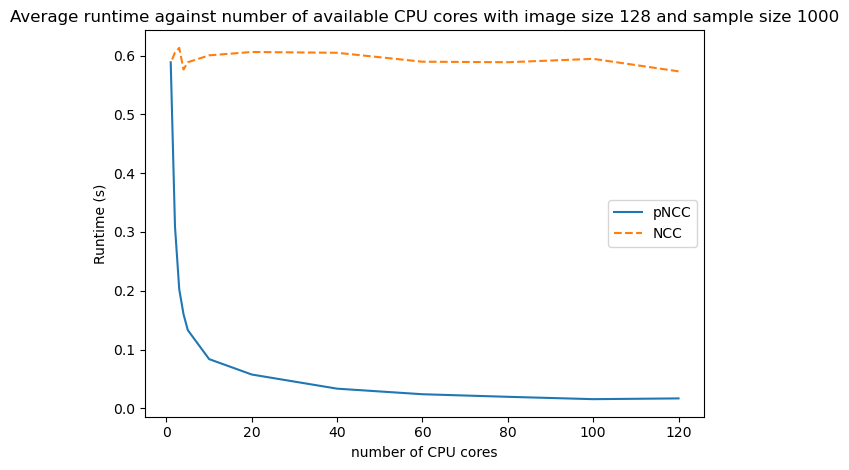

In [72]:
#cores = [1,2,3,4,5,10,20,40,60,80,100,120]
cores = [120,100,80,60,40,20,10,5,4,3,2,1]
# left 2,3,4 after 1
# avgs_pncc = [0.5885079167108052, 0.3093975507165305, 0.20234855002257973, 0.1602316380175762, 0.13320948843844235, 0.08386606069281698, 0.05765277410158887, 0.03361522084334865, 0.02414203777909279, 0.019773877474945037, 0.01578121086815372, 0.017061848072335125]
avgs_pncc = [0.017061848072335125, 0.01578121086815372, 0.019773877474945037, 0.02414203777909279, 0.03361522084334865, 0.05765277410158887, 0.08386606069281698, 0.13320948843844235, 0.1602316380175762, 0.20234855002257973, 0.3093975507165305, 0.5885079167108052]
# avgs_ncc = [0.5877212696126662, 0.6049848415027372, 0.6129751214175485, 0.5762144492077641, 0.5885769659420476, 0.6002986337337642, 0.6060150211583823, 0.6046791893430055, 0.5895023250533268, 0.5886137371766381, 0.5943542667594738, 0.5731154200134541]
avgs_ncc = [0.5731154200134541, 0.5943542667594738, 0.5886137371766381, 0.5895023250533268, 0.6046791893430055, 0.6060150211583823, 0.6002986337337642, 0.5885769659420476, 0.5762144492077641, 0.6129751214175485, 0.6049848415027372, 0.5877212696126662]


plot_data_pncc_cores(x_axis="number of CPU cores", title="Average runtime against number of available CPU cores with image size 128 and sample size 1000", filename="/home/jovyan/evaluation/results/test_num_cores_pncc.png", varied_arr=cores, data1=avgs_pncc, data2=avgs_ncc)

In [68]:
def invert(arr):
    ret = []
    for i in range(1, len(arr)+1):
        ret.append(arr[-i])
    
    return ret

In [70]:
arr = invert(avgs_ncc)
print(arr)

[0.5731154200134541, 0.5943542667594738, 0.5886137371766381, 0.5895023250533268, 0.6046791893430055, 0.6060150211583823, 0.6002986337337642, 0.5885769659420476, 0.5762144492077641, 0.6129751214175485, 0.6049848415027372, 0.5877212696126662]


In [98]:
sardet_ncc = [0.05521593143542607, 0.5417954588852202, 1.0733335714166363, 1.5438002542747806, 2.117335267760791, 2.602669185291355, 3.285998824960552, 3.717141487550301, 4.065622979301649, 4.594193572093112]
sardet_mtree = [0.05145432933544119, 0.4083963114613046, 0.8909139870122696, 1.2157006656906257, 1.7326357159297914, 2.230820569450346, 2.749804117142533, 3.328286027163267, 4.253589039947838, 4.009387365790705]

mstar_ncc = [0.06432683169065664, 0.5721337169564019, 1.1391131965753933, 1.8031199592243259, 2.2729833242561046, 2.8127336614221954, 3.254611448516759, 3.663294882125532, 4.1460548933440196, 4.637732347326042]
mstar_mtree = [0.05731044242468973, 0.570239573600702, 1.236585020716302, 1.892330951942131, 2.369726385214987, 3.0768407956774655, 4.626157839200459, 4.864217841361339, 5.095407685901349, 6.7481001256033775]

def compare(arr1, arr2):
    res = []
    for i in range(len(arr1)):
        res.append(((arr1[i] - arr2[i]) / arr2[i]) * 100)

    return res

In [99]:
print(compare(sardet_ncc, sardet_mtree))

[7.310564822373329, 32.664141100244755, 20.47555511123145, 26.9885176379142, 22.20314104656193, 16.668692271052034, 19.499378318452994, 11.683354652017673, -4.41899908244295, 14.585924305846559]


In [23]:
def plot_perf_compaison(x_axis="", title="", filename="", varied_arr=[], data1=[], data2=[], data3=[], data4=[]):
    data_ATRNET = []
    data_IMDB = []
    data_MSTAR = []
    data_SARDET = []
    
    for i in range(len(varied_arr)):
        data_ATRNET.append([varied_arr[i], data1[i]])
        data_IMDB.append([varied_arr[i], data2[i]])
        data_MSTAR.append([varied_arr[i], data3[i]])
        data_SARDET.append([varied_arr[i], data4[i]])

    # print(data_ncc)
    # print(data_mtree)
    data_ATRNET = np.array(data_ATRNET)
    data_IMDB = np.array(data_IMDB)
    data_MSTAR = np.array(data_MSTAR)
    data_SARDET = np.array(data_SARDET)

    x_ATRNET, y_ATRNET = data_ATRNET.T
    x_IMDB, y_IMDB = data_IMDB.T
    x_MSTAR, y_MSTAR = data_MSTAR.T
    x_SARDET, y_SARDET = data_SARDET.T

    w, x = 350, np.array(varied_arr)

    plt.bar(x, y_ATRNET, w/2, label="ATRNET")
    plt.bar(x + w, y_IMDB, w/2, label="IMDB")
    plt.bar(x + w/2, y_MSTAR, w/2, label="MSTAR")
    plt.bar(x + 3/2 * w, y_SARDET, w/2, label="SARDET")

    # plt.xticks(x, varied_arr)
    # plt.plot(x_ATRNET, y_ATRNET, label = "ATRNET", linestyle="-")
    # plt.plot(x_IMDB, y_IMDB, label = "IMDB", linestyle="--")
    # plt.plot(x_MSTAR, y_MSTAR, label = f"MSTAR", linestyle=":")
    # plt.plot(x_SARDET, y_SARDET, label = f"SARDET", linestyle="-.")
    plt.legend()
    plt.xlabel(x_axis)  # Title for the x-axis
    plt.ylabel("performance improvement (%)")  # Title for the y-axis
    plt.title(title)
    plt.tight_layout()
    # plt.show()
    plt.savefig(filename, bbox_inches='tight', dpi=1000)



#     cats = ['A', 'B', 'C', 'D']
# v1, v2 = [4, 7, 1, 8], [5, 6, 2, 9]
# w, x = 0.4, np.arange(len(cats))

# plt.bar(x - w/2, v1, w, label='Set 1')
# plt.bar(x + w/2, v2, w, label='Set 2')

# plt.xticks(x, cats)
# plt.ylabel('Values')
# plt.title('Grouped Bar Chart')
# plt.legend()
# plt.show()

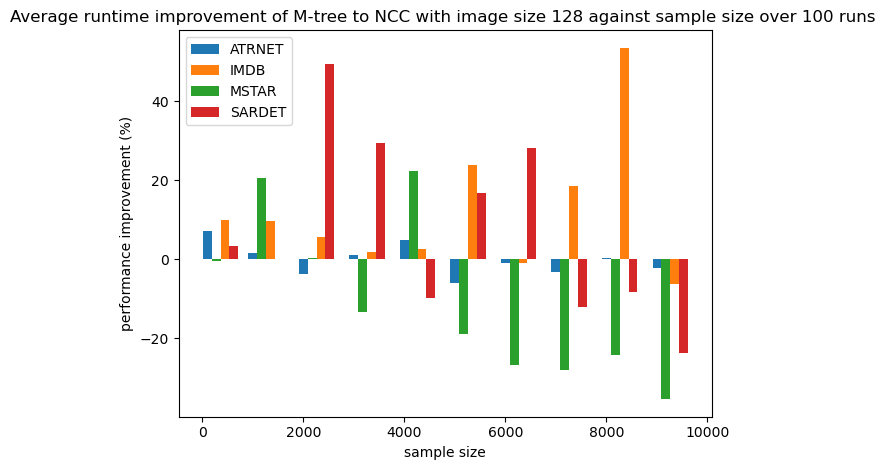

In [24]:
sample_sizes = [100, 1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000]
p_incs_imdb = [9.863526652734942, 9.629246923859728, 5.636304595538517, 1.9229417458416123, 2.464951952796785, 23.700885164233124, -1.048021809198937, 18.456750709027542, 53.46853265821929, -6.414550201082368]
p_incs_MSTAR = [-0.5047790724726271, 20.61529974920684, 0.31902896895605176, -13.309722567209306, 22.20314104656193, -18.8634108780993, -26.85631776740225, -27.940563366122657, -24.344913522918777, -35.444127542627776]
p_incs_SARDET = [3.3796928049832213, 0.09538534272708911, 49.33360421170683, 29.41481834760192, -9.897917226929128, 16.668692271052034, 28.01090303164392, -12.198051763727944, -8.335171428558414, -23.81247084271034]
p_incs_ATRNET = [7.027604247627268, 1.4636833373560956, -3.6650520485611295, 0.9675689213581813, 4.874493320859717, -6.130568062882365, -0.9729596516400096, -3.3261233923058153, 0.41123916040104685, -2.3415477738685406]

plot_perf_compaison(x_axis="sample size", title="Average runtime improvement of M-tree to NCC with image size 128 against sample size over 100 runs ", filename="/home/jovyan/evaluation/results/perf_improvement.png", varied_arr=sample_sizes, data1=p_incs_ATRNET, data2=p_incs_imdb, data3=p_incs_MSTAR, data4=p_incs_SARDET)


In [128]:
def save_list_data(image_size):

    data = get_data_SARDet_100k(image_size)


    testSample = [item[0] for item in data]
    print("Done w testSample")


    filename = "/home/jovyan/data/annotations/sardet_list_data_all_128.npz"
    np.savez(filename, testSample=testSample)

In [ ]:
save_list_data(128)

Done w testSample
